In [414]:
from hexipy.exposure import LongExposure
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.utils.console import ProgressBar
import scipy.interpolate as inter


In [2]:
e = LongExposure('/Users/schriste/Data/hexitec/hexitec_packets_20160603_212356.dat')

.data[1451833:?]  |  No valid checksum found, possible end at :1451905
.data[1799093:?]  |  No valid checksum found, possible end at :1799138
.data[2303749:?]  |  No valid checksum found, possible end at :2303813
.data[2664978:?]  |  No valid checksum found, possible end at :2665041
.data[2998749:?]  |  No valid checksum found, possible end at :2998751
.data[3709991:?]  |  No valid checksum found, possible end at :3710046
.data[3942252:?]  |  No valid checksum found, possible end at :3942254
.data[4369474:?]  |  No valid checksum found, possible end at :4369569
.data[5003331:?]  |  No valid checksum found, possible end at :5003380
.data[6674902:?]  |  No valid checksum found, possible end at :6674952
.data[9292542:?]  |  No valid checksum found, possible end at :9292613
.data[9618462:?]  |  No valid checksum found, possible end at :9618524
.data[9696258:?]  |  No valid checksum found, possible end at :9696300
.data[10683828:?]  |  No valid checksum found, possible end at :10683915
.dat

In [3]:
e

HEXITEC Exposure <8,567,071±2,926 counts 557.033448 s 15,379±5 cps> 

In [4]:
e.describe()

parameters,value
str20,float64
Percent Read,99.9999982752
Integration Time (s),557.033448
Total counts,"8,567,071.14776"
Total counts error,"2,926.95592724"
Counts Rate,"15,379.8143195"
Counts Rate Error,5.25454250144
Counts per Frame,9.7315259297
Channel Low,"2,679.0"
Channel High,"16,383.0"


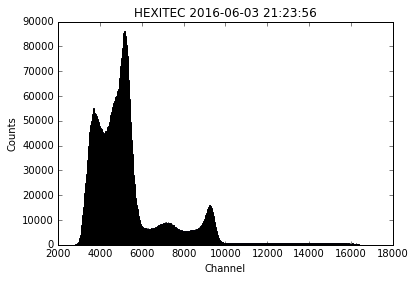

In [8]:
e.plot_spectrum()

In [17]:
pixel_index = (23, 34)

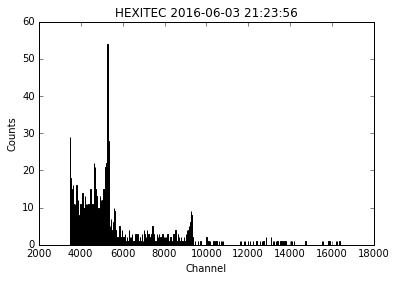

In [18]:
e.plot_spectrum(pixel_index=pixel_index)

# Defining the fit function

In [167]:
from astropy.modeling.models import custom_model
def step_function(x, mean, bkg1, bkg2):
    return (bkg2 - bkg1) * 0.5 * (np.sign(x - mean) + 1) + bkg1

@custom_model
def emission_line(x, amplitude=1., mean=1., stddev=1., bkg1=1., bkg2=1.):
    return (amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)) + step_function(x, mean, bkg1, bkg2)

# Fit the 30.9 keV line

In [332]:
hist, bins = e.spectrum(pixel_index=pixel_index)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
m, argmax = (hist.max(), bins[hist.argmax()])
g = models.Gaussian1D(amplitude=m, mean=argmax, stddev=30)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(g, center, hist)



In [333]:
print(t.mean)
print(t.stddev)
#print(t.bkg1)
#print(t.bkg2)

Parameter('mean', value=5098.54298882)
Parameter('stddev', value=46.598968279)


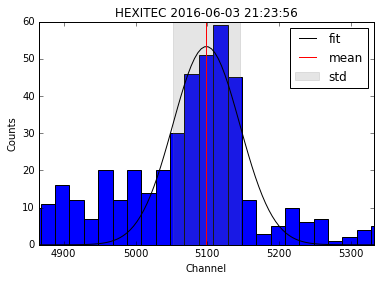

In [334]:
e.plot_spectrum(pixel_index=pixel_index)
fit_x = np.linspace(t.mean - 5 * t.stddev, t.mean + 5 * t.stddev, 100)
plt.plot(fit_x, t(fit_x), label='fit', color='black')
plt.axvline(t.mean, color='red', label='mean')
plt.axvspan(t.mean - t.stddev, t.mean + t.stddev, color='grey', alpha = 0.2, label='std')
plt.xlim(t.mean - 5 * t.stddev, t.mean + 5 * t.stddev)
plt.legend()

In [ ]:
t.

# Find the 80.9 keV line

In [63]:
from scipy import signal
peakind = signal.find_peaks_cwt(hist, np.arange(30,40))
peakind, center[peakind], hist[peakind]

([80, 283, 495, 627],
 array([ 5077,  9137, 13377, 16017]),
 array([15,  4,  1,  0]))

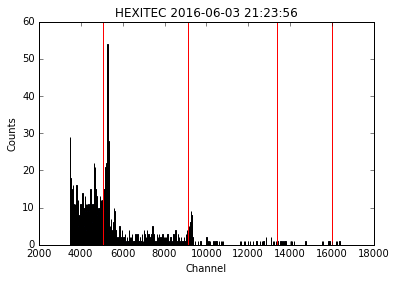

In [64]:
e.plot_spectrum(pixel_index=pixel_index)
for peak in center[peakind]:
    plt.axvline(peak, color='red', label='mean')

In [65]:
center[peakind][1]

9137

# Fitting the 80.9 keV line

In [329]:
hist, bins = e.spectrum(pixel_index=pixel_index)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

g = models.Gaussian1D(amplitude=m * 0.2, mean=center[peakind][1], stddev=30)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(g, center, hist)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [74]:
print(t.mean)
print(t.stddev)

Parameter('mean', value=9254.37467207)
Parameter('stddev', value=69.3977526117)


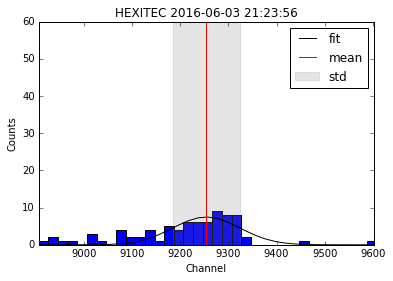

In [75]:
e.plot_spectrum(pixel_index=pixel_index)
plt.plot(center, t(center), label='fit', color='black')
plt.axvline(t.mean, color='red', label='mean')
plt.axvspan(t.mean - t.stddev, t.mean + t.stddev, color='grey', alpha = 0.2, label='std')
plt.xlim(t.mean - 5 * t.stddev, t.mean + 5 * t.stddev)
plt.legend()

# Putting it all together

In [605]:
def fit_line(x, y, guess):
    g = models.Gaussian1D(amplitude=guess[0], mean=guess[1], stddev=guess[2])
    #g.bounds = {'mean': (guess[1] - 0.1 * guess[1], guess[1] + 0.1 * guess[1])}
    fit_func = fitting.LevMarLSQFitter()
    fit = fit_func(g, x, y)
    return fit

def guess_peak_index(x, y, search_range=None):
    this_y = y.copy()
    if search_range is None:
        result = (y.max(), x[y.argmax()])
    else:
        this_y = y.copy()
        this_y[x < search_range[0]] = 0
        this_y[x > search_range[1]] = 0
        result = (this_y.max(), x[this_y.argmax()])
    return result

def find_pixel_gain(spectrum, verbose=False):
    # fit the strong line first
    hist, bins = spectrum
    x = (bins[:-1] + bins[1:]) / 2
    # find the location of the strong line
    m1, x1 = guess_peak_index(x, hist)

    # find the location of the high energy line
    m2, x2 = guess_peak_index(x, hist, search_range=[8000, 10000])
    
    if verbose:
        print(peakind)
    # first line
    guess = (m1, x1, 30)
    fit = fit_line(x, hist, guess)
    
    result = np.zeros(2)
    
    result[0] = fit.mean.value
    # second line
    guess = (m2, x2, 30)
    fit = fit_line(x, hist, guess)
    result[1] = fit.mean.value
    return np.clip(result, 0, 2**14)

def is_bad_pixels(spectrum):
    hist, bins = spectrum
    return (bins.max() - bins.min()) < 5000

def find_all_gains(e):
    """Returns an array with channel number of line"""
    lines_locs = np.zeros((80, 80, 2))
    bad_pixel_count = 0
    bad_fit_count = 0
    with ProgressBar(80 * 80) as bar:
        for ix in np.arange(0, 80):
            for iy in np.arange(0, 80):
                bar.update()
                try:
                    spectrum = e.spectrum(pixel_index=(ix, iy))
                except:
                    print(ix, iy)
                    bad_pixel_count += 1
                    pass
                if not is_bad_pixels(spectrum):
                    try:
                        result = find_pixel_gain(spectrum)
                        lines_locs[ix, iy, 0] = result[0]
                        lines_locs[ix, iy, 1] = result[1]
                        if (result[0] == 0) or (result[1] == 0):
                            bad_fit_count += 1
                    except:
                        print(ix, iy)
                        
                else:
                    bad_pixel_count += 1
    
    print("{0}% bad pixels".format(bad_pixel_count/(80*80)))
    print("{0}% bad fits".format(bad_fit_count/(80*80)))
    plt.imshow(lines_locs[:,:,0])
    return lines_locs

def check_pixel(pixel_index):
    result = find_pixel_gain(e.spectrum(pixel_index=pixel_index), verbose=True)
    e.plot_spectrum(pixel_index=pixel_index)
    plt.axvline(result[0], color='red', label='mean')
    print(result)
    plt.axvline(result[1], color='red', label='mean')    

def pixel_gain_function(pixel_index):
    return np.poly1d((m[pixel_index], offset[pixel_index]))

def pixel_energy_axis(pixel_index):
    hist, bins = e.spectrum(pixel_index=pixel_index)
    center = (bins[:-1] + bins[1:]) / 2
    return pixel_gain_function(pixel_index)(center)

def calculate_fwhm(sigma):
    return 2 * np.sqrt(2 * np.log(2)) * sigma

def plot_corrected_spectrum(pixel_index):
    hist, bins = e.spectrum(pixel_index=pixel_index)
    width = 1 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    energy = pixel_gain_function(pixel_index)(center)
    plt.plot(energy, hist)
    plt.ylabel('Counts')
    plt.xlabel('Energy')
    
def get_fwhm(line_energy, pixel_index):
    energies = pixel_energy_axis(pixel_index)
    hist, bins = e.spectrum(pixel_index)
    guess = (50, line_energy, 1)
    bounding_box = (energies < line_energy + guess[2] * 3) & (energies > line_energy - guess[2] * 3)
    fit = fit_line(energies[bounding_box], hist[bounding_box], guess)
    return fit

def find_all_fwhm(line_energy=30.9):
    fwhm = np.zeros((80, 80))
    for ix in np.arange(0, 80):
        for iy in np.arange(0, 80):
            try:
                f = get_fwhm(30.9, (ix, iy))
                fwhm[ix, iy] = calculate_fwhm(f.stddev)
            except:
                pass
    return fwhm

def calculate_gain_and_offset(channel_list, energy_list = [30.9, 80.9]):
    result = np.zeros((80,80,2))
    # calculate the slope (i.e. the gain)
    result[:,:,1] = np.clip((energy_list[1] - energy_list[0]) / (channel_list[:,:,1] - channel_list[:,:,0]), 1e-4, 2)
    # calculate the offset
    result[:,:,0] = energy_list[0] - m * result[:,:,0]
    return result

def plot_total_spectrum():
    pass



(30, 0)
0% bad pixels
0% bad fits


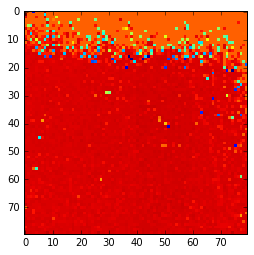

In [324]:
result = find_all_gains(e)

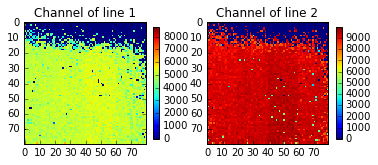

In [591]:
f, axes = plt.subplots(1, 2)
cs = axes[0].imshow(result[:,:,0], vmin=0)
f.colorbar(cs, ax=axes[0], shrink=0.5)
axes[0].set_title('Channel of line 1')
cs = axes[1].imshow(result[:,:,1], vmin=0)
f.colorbar(cs, ax=axes[1], shrink=0.5)
axes[1].set_title('Channel of line 2')

(0, 10000.0)

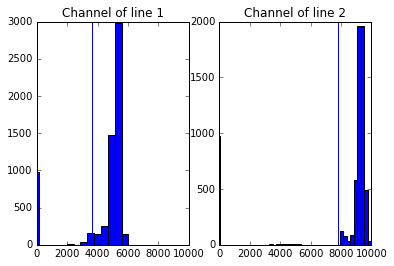

In [603]:
f, axes = plt.subplots(1, 2)
axes[0].hist(result[:,:,0].flatten(), bins=100);
axes[0].set_xlim(0)
axes[0].axvline(result[:,:,0].flatten().mean())
axes[0].set_title('Channel of line 1')
axes[1].hist(result[:,:,1].flatten(), bins=100);
axes[1].axvline(result[:,:,1].flatten().mean())
axes[1].set_title('Channel of line 2')
axes[1].set_xlim(0)

In [607]:
gain_offset = calculate_gain_and_offset(result)

In [583]:
m = np.clip((80.9 - 30.9) / (result[:,:,1] - result[:,:,0]), 1e-4, 2)
offset = 30.9 - m * result[:,:,0]

In [609]:
gain_offset[:,:,1].mean()

0.31483410500574482

(0, 0.05)

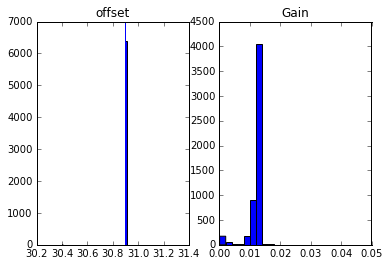

In [617]:
f, axes = plt.subplots(1, 2)
axes[0].hist(gain_offset[:,:,0].flatten(), bins=100);
#axes[0].set_xlim(0)
axes[0].axvline(gain_offset[:,:,0].flatten().mean())
axes[0].set_title('offset')
axes[1].hist(gain_offset[:,:,1].flatten(), bins=1000);
axes[1].axvline(gain_offset[:,:,1].flatten().mean())
axes[1].set_title('Gain')
axes[1].set_xlim(0, 0.05)

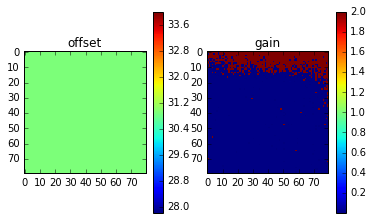

In [618]:
f, axes = plt.subplots(1, 2)
cs = axes[0].imshow(gain_offset[:,:,0])
axes[0].set_title('offset')
f.colorbar(cs, ax=axes[0], shrink=0.9)
cs = axes[1].imshow(gain_offset[:,:,1])
axes[1].set_title('gain')
f.colorbar(cs, ax=axes[1], shrink=0.9)

1.28779546489


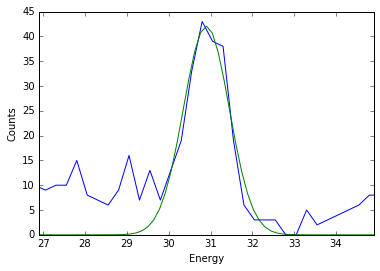

In [556]:
line_energy = 30.9
pixel_index = (45, 50)
plot_corrected_spectrum(pixel_index)
f = get_fwhm(30.9, pixel_index)
x = np.linspace(10,80,500)
plt.plot(x, f(x))
plt.xlim(line_energy - 1 * 4, line_energy + 1 * 4)
print(calculate_fwhm(f.stddev))

In [498]:
pixel_index = (60,40)
energies = pixel_energy_axis(pixel_index)
bins, hist = e.spectrum(pixel_index)

In [ ]:
fwhm = find_all_fwhm()

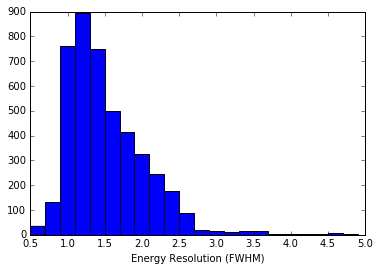

In [569]:
plt.hist(fwhm.flatten(), bins=np.arange(0.5,5,0.2));
plt.xlabel('Energy Resolution (FWHM)')

In [328]:
result[:,:,1].max()

9985.0